In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
import matplotlib
import statsmodels
import tensorflow as tf

C:\Users\hirot\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
print(pd.__version__)
print(matplotlib.__version__)
print(statsmodels.__version__)
print(tf.__version__)

1.3.4
3.4.3
0.12.2
2.12.0


In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
tf.random.set_seed(5210)

In [5]:
accident2019 = pd.read_csv("Data/honhyo_2019.csv", encoding="Shift-JIS")
accident_additional_2019 = pd.read_csv("Data/hojuhyo_2019.csv", encoding="Shift-JIS")
accident_motorway_2019 = pd.read_csv("Data/kosokuhyo_2019.csv", encoding="Shift-JIS")

In [6]:
accident2020 = pd.read_csv("Data/honhyo_2020.csv", encoding="Shift-JIS")
accident_additional_2020 = pd.read_csv("Data/hojuhyo_2020.csv", encoding="Shift-JIS")
accident_motorway_2020 = pd.read_csv("Data/kosokuhyo_2020.csv", encoding="Shift-JIS")

In [7]:
accident2021 = pd.read_csv("Data/honhyo_2021.csv", encoding="Shift-JIS")
accident_additional_2021 = pd.read_csv("Data/hojuhyo_2021.csv", encoding="Shift-JIS")
accident_motorway_2021 = pd.read_csv("Data/kosokuhyo_2021.csv", encoding="Shift-JIS")

In [8]:
accident_all = pd.concat([accident2019,accident2020,accident2021])
accident_all.shape

(995611, 58)

In [9]:
accident2019["date"] = pd.to_datetime({"year":accident2019["発生日時　　年"],"month":accident2019["発生日時　　月"],
                                       "day":accident2019["発生日時　　日"]})
accident_all["date"] = pd.to_datetime({"year":accident_all["発生日時　　年"],"month":accident_all["発生日時　　月"],
                                       "day":accident_all["発生日時　　日"]})

In [10]:
ts = accident_all[["date","資料区分"]].groupby("date").count()
ts["資料区分"].sum()

995611

In [11]:
ts.columns=["accident_num"]

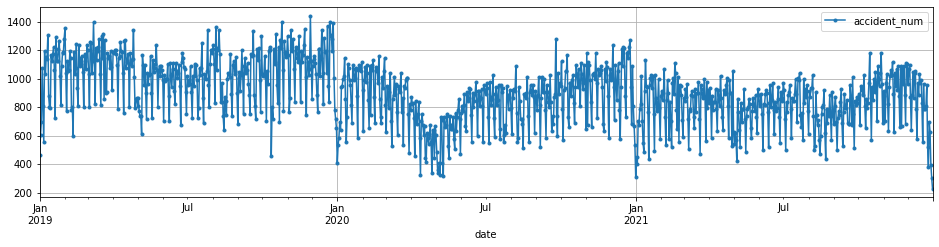

In [12]:
ts["2019-01":"2022-12"].plot(grid=True, marker=".", figsize=(16, 3.5))
plt.show()

In [13]:
# normalise the data with minmax
accident_train = (ts["accident_num"]["2019-01":"2020-12"]-1) / (1442-1)
accident_valid = (ts["accident_num"]["2021-01":"2021-11"]-1) / (1442-1)
accident_test = (ts["accident_num"]["2021-12":]-1) / (1442-1)

In [14]:
seq_length = 56
train_ds = tf.keras.utils.timeseries_dataset_from_array(
    accident_train.to_numpy(),
    targets=accident_train[seq_length:],
    sequence_length=seq_length,
    batch_size=32,
#    shuffle=True,
    seed=42
)
valid_ds = tf.keras.utils.timeseries_dataset_from_array(
    accident_valid.to_numpy(),
    targets=accident_valid[seq_length:],
    sequence_length=seq_length,
    batch_size=32
)

In [15]:
rnn_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, input_shape=[None, 1]),
    tf.keras.layers.Dense(1) # no activation function by default
])
early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    monitor="val_mae", patience=50, restore_best_weights=True)
opt = tf.keras.optimizers.SGD(learning_rate=0.02, momentum=0.9)
rnn_model.compile(loss=tf.keras.losses.Huber(), optimizer=opt, metrics=["mae"])
history = rnn_model.fit(train_ds, validation_data=valid_ds, epochs=500,
    callbacks=[early_stopping_cb])

Epoch 1/500
22/22 [==============================] - 1s 16ms/step - loss: 0.0647 - mae: 0.2762 - val_loss: 0.0127 - val_mae: 0.1322
Epoch 2/500
22/22 [==============================] - 0s 7ms/step - loss: 0.0121 - mae: 0.1264 - val_loss: 0.0122 - val_mae: 0.1301
Epoch 3/500
22/22 [==============================] - 0s 6ms/step - loss: 0.0108 - mae: 0.1195 - val_loss: 0.0212 - val_mae: 0.1839
Epoch 4/500
22/22 [==============================] - 0s 6ms/step - loss: 0.0113 - mae: 0.1229 - val_loss: 0.0112 - val_mae: 0.1235
Epoch 5/500
22/22 [==============================] - 0s 7ms/step - loss: 0.0082 - mae: 0.1022 - val_loss: 0.0045 - val_mae: 0.0746
Epoch 6/500
22/22 [==============================] - 0s 6ms/step - loss: 0.0075 - mae: 0.0977 - val_loss: 0.0046 - val_mae: 0.0758
Epoch 7/500
22/22 [==============================] - 0s 6ms/step - loss: 0.0072 - mae: 0.0957 - val_loss: 0.0040 - val_mae: 0.0702
Epoch 8/500
22/22 [==============================] - 0s 6ms/step - loss: 0.0070 - 

22/22 [==============================] - 0s 6ms/step - loss: 0.0035 - mae: 0.0627 - val_loss: 0.0024 - val_mae: 0.0515
Epoch 64/500
22/22 [==============================] - 0s 6ms/step - loss: 0.0035 - mae: 0.0626 - val_loss: 0.0024 - val_mae: 0.0513
Epoch 65/500
22/22 [==============================] - 0s 6ms/step - loss: 0.0035 - mae: 0.0625 - val_loss: 0.0024 - val_mae: 0.0512
Epoch 66/500
22/22 [==============================] - 0s 6ms/step - loss: 0.0035 - mae: 0.0624 - val_loss: 0.0024 - val_mae: 0.0510
Epoch 67/500
22/22 [==============================] - 0s 6ms/step - loss: 0.0035 - mae: 0.0623 - val_loss: 0.0024 - val_mae: 0.0509
Epoch 68/500
22/22 [==============================] - 0s 6ms/step - loss: 0.0035 - mae: 0.0622 - val_loss: 0.0023 - val_mae: 0.0507
Epoch 69/500
22/22 [==============================] - 0s 6ms/step - loss: 0.0035 - mae: 0.0621 - val_loss: 0.0023 - val_mae: 0.0506
Epoch 70/500
22/22 [==============================] - 0s 6ms/step - loss: 0.0035 - mae: 0

Epoch 125/500
22/22 [==============================] - 0s 6ms/step - loss: 0.0030 - mae: 0.0573 - val_loss: 0.0023 - val_mae: 0.0487
Epoch 126/500
22/22 [==============================] - 0s 6ms/step - loss: 0.0030 - mae: 0.0572 - val_loss: 0.0023 - val_mae: 0.0487
Epoch 127/500
22/22 [==============================] - 0s 7ms/step - loss: 0.0030 - mae: 0.0572 - val_loss: 0.0023 - val_mae: 0.0487
Epoch 128/500
22/22 [==============================] - 0s 6ms/step - loss: 0.0030 - mae: 0.0571 - val_loss: 0.0023 - val_mae: 0.0487
Epoch 129/500
22/22 [==============================] - 0s 6ms/step - loss: 0.0030 - mae: 0.0570 - val_loss: 0.0023 - val_mae: 0.0487
Epoch 130/500
22/22 [==============================] - 0s 6ms/step - loss: 0.0030 - mae: 0.0569 - val_loss: 0.0023 - val_mae: 0.0487
Epoch 131/500
22/22 [==============================] - 0s 6ms/step - loss: 0.0030 - mae: 0.0568 - val_loss: 0.0023 - val_mae: 0.0487
Epoch 132/500
22/22 [==============================] - 0s 6ms/step - 

In [16]:
# Execute 1 month analysis
import numpy as np
X = accident_valid.to_numpy()[np.newaxis, len(accident_valid)-seq_length:len(accident_valid), np.newaxis]
print(len(X[0]))
for step_ahead in range(31):
    y_pred_one = rnn_model.predict(X)
    print(len(X[0]))
    print(y_pred_one)
    X = np.concatenate([X, y_pred_one.reshape(1, 1, 1)], axis=1)

56
1/1 [==============================] - 0s 100ms/step
56
[[0.7490481]]
1/1 [==============================] - 0s 99ms/step
57
[[0.7779517]]
1/1 [==============================] - 0s 16ms/step
58
[[0.7648284]]
1/1 [==============================] - 0s 16ms/step
59
[[0.575458]]
1/1 [==============================] - 0s 15ms/step
60
[[0.45138475]]
1/1 [==============================] - 0s 16ms/step
61
[[0.59994406]]
1/1 [==============================] - 0s 14ms/step
62
[[0.6225739]]
1/1 [==============================] - 0s 16ms/step
63
[[0.5148282]]
1/1 [==============================] - 0s 23ms/step
64
[[0.57083297]]
1/1 [==============================] - 0s 16ms/step
65
[[0.5822264]]
1/1 [==============================] - 0s 16ms/step
66
[[0.49276847]]
1/1 [==============================] - 0s 15ms/step
67
[[0.3265539]]
1/1 [==============================] - 0s 16ms/step
68
[[0.5156479]]
1/1 [==============================] - 0s 16ms/step
69
[[0.45753518]]
1/1 [=====================

In [17]:
X_array=X.flatten()

In [18]:
len(X_array)

87

In [19]:
len(ts["accident_num"]["2021-10-06":"2021-12"].tolist())

87

In [20]:
xaxis = list(range(87))
print(xaxis)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86]


In [21]:
xaxis = pd.date_range(start='12/1/2021', end='12/31/2021')
print(xaxis)

DatetimeIndex(['2021-12-01', '2021-12-02', '2021-12-03', '2021-12-04',
               '2021-12-05', '2021-12-06', '2021-12-07', '2021-12-08',
               '2021-12-09', '2021-12-10', '2021-12-11', '2021-12-12',
               '2021-12-13', '2021-12-14', '2021-12-15', '2021-12-16',
               '2021-12-17', '2021-12-18', '2021-12-19', '2021-12-20',
               '2021-12-21', '2021-12-22', '2021-12-23', '2021-12-24',
               '2021-12-25', '2021-12-26', '2021-12-27', '2021-12-28',
               '2021-12-29', '2021-12-30', '2021-12-31'],
              dtype='datetime64[ns]', freq='D')


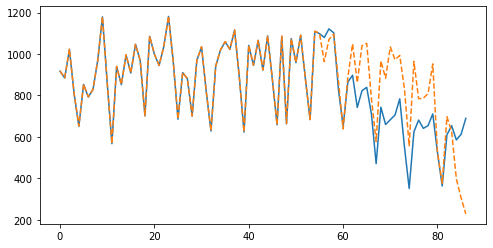

In [22]:
fig, ax = plt.subplots(figsize=(8, 4))
#accident_series[time_period].plot(ax=ax, marker=".")
#y_preds.plot(ax=ax, grid=True, legend=False)
plt.plot(X_array*1441, linestyle="solid")
plt.plot(ts["accident_num"]["2021-10-06":"2021-12"].tolist(), linestyle="dashed")
plt.show()

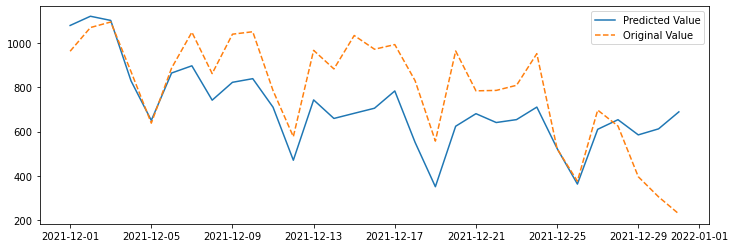

MAE: 160.20184457494366
MAPE: 26.09129232893823
RMSE: 197.14731867269768


In [23]:
fig, ax = plt.subplots(figsize=(12, 4))
#accident_series[time_period].plot(ax=ax, marker=".")
#y_preds.plot(ax=ax, grid=True, legend=False)
plt.plot(xaxis, X_array[len(X_array)-31:len(X_array)]*1441, linestyle="solid", label='Predicted Value')
plt.plot(xaxis, ts["accident_num"]["2021-12":].tolist(), linestyle="dashed", label='Original Value')
plt.legend()
plt.show()

mae = np.abs(ts["accident_num"]["2021-12":].tolist() - X_array[len(X_array)-31:len(X_array)]*1441).mean()
mape = 100*np.abs(((X_array[len(X_array)-31:len(X_array)]*1441 - ts["accident_num"]["2021-12":].tolist())/ts["accident_num"]["2021-12":].tolist())).mean()
rmse = ((X_array[len(X_array)-31:len(X_array)]*1441 - ts["accident_num"]["2021-12":].tolist())**2).mean()**0.5

print("MAE: "+str(mae))
print("MAPE: "+str(mape))
print("RMSE: "+str(rmse))

In [24]:
seq_length = 112
train_ds = tf.keras.utils.timeseries_dataset_from_array(
    accident_train.to_numpy(),
    targets=accident_train[seq_length:],
    sequence_length=seq_length,
    batch_size=32,
#    shuffle=True,
    seed=42
)
valid_ds = tf.keras.utils.timeseries_dataset_from_array(
    accident_valid.to_numpy(),
    targets=accident_valid[seq_length:],
    sequence_length=seq_length,
    batch_size=32
)

In [25]:
rnn_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, input_shape=[None, 1]),
    tf.keras.layers.Dense(1) # no activation function by default
])
early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    monitor="val_mae", patience=50, restore_best_weights=True)
opt = tf.keras.optimizers.SGD(learning_rate=0.02, momentum=0.9)
rnn_model.compile(loss=tf.keras.losses.Huber(), optimizer=opt, metrics=["mae"])
history = rnn_model.fit(train_ds, validation_data=valid_ds, epochs=500,
    callbacks=[early_stopping_cb])

Epoch 1/500
20/20 [==============================] - 1s 16ms/step - loss: 0.0126 - mae: 0.1250 - val_loss: 0.0061 - val_mae: 0.0857
Epoch 2/500
20/20 [==============================] - 0s 10ms/step - loss: 0.0078 - mae: 0.0999 - val_loss: 0.0126 - val_mae: 0.1370
Epoch 3/500
20/20 [==============================] - 0s 10ms/step - loss: 0.0096 - mae: 0.1129 - val_loss: 0.0184 - val_mae: 0.1729
Epoch 4/500
20/20 [==============================] - 0s 9ms/step - loss: 0.0079 - mae: 0.1012 - val_loss: 0.0044 - val_mae: 0.0735
Epoch 5/500
20/20 [==============================] - 0s 11ms/step - loss: 0.0053 - mae: 0.0810 - val_loss: 0.0061 - val_mae: 0.0895
Epoch 6/500
20/20 [==============================] - 0s 10ms/step - loss: 0.0055 - mae: 0.0830 - val_loss: 0.0054 - val_mae: 0.0831
Epoch 7/500
20/20 [==============================] - 0s 11ms/step - loss: 0.0052 - mae: 0.0806 - val_loss: 0.0053 - val_mae: 0.0829
Epoch 8/500
20/20 [==============================] - 0s 9ms/step - loss: 0.00

Epoch 63/500
20/20 [==============================] - 0s 10ms/step - loss: 0.0035 - mae: 0.0624 - val_loss: 0.0027 - val_mae: 0.0567
Epoch 64/500
20/20 [==============================] - 0s 9ms/step - loss: 0.0035 - mae: 0.0624 - val_loss: 0.0027 - val_mae: 0.0567
Epoch 65/500
20/20 [==============================] - 0s 10ms/step - loss: 0.0035 - mae: 0.0624 - val_loss: 0.0027 - val_mae: 0.0567
Epoch 66/500
20/20 [==============================] - 0s 9ms/step - loss: 0.0035 - mae: 0.0623 - val_loss: 0.0027 - val_mae: 0.0567
Epoch 67/500
20/20 [==============================] - 0s 10ms/step - loss: 0.0035 - mae: 0.0623 - val_loss: 0.0027 - val_mae: 0.0567
Epoch 68/500
20/20 [==============================] - 0s 10ms/step - loss: 0.0035 - mae: 0.0622 - val_loss: 0.0027 - val_mae: 0.0568
Epoch 69/500
20/20 [==============================] - 0s 11ms/step - loss: 0.0035 - mae: 0.0622 - val_loss: 0.0027 - val_mae: 0.0568
Epoch 70/500
20/20 [==============================] - 0s 10ms/step - lo

20/20 [==============================] - 0s 9ms/step - loss: 0.0033 - mae: 0.0597 - val_loss: 0.0029 - val_mae: 0.0585
Epoch 125/500
20/20 [==============================] - 0s 10ms/step - loss: 0.0033 - mae: 0.0596 - val_loss: 0.0029 - val_mae: 0.0586
Epoch 126/500
20/20 [==============================] - 0s 10ms/step - loss: 0.0033 - mae: 0.0594 - val_loss: 0.0029 - val_mae: 0.0586
Epoch 127/500
20/20 [==============================] - 0s 10ms/step - loss: 0.0033 - mae: 0.0594 - val_loss: 0.0029 - val_mae: 0.0586
Epoch 128/500
20/20 [==============================] - 0s 10ms/step - loss: 0.0033 - mae: 0.0593 - val_loss: 0.0029 - val_mae: 0.0586
Epoch 129/500
20/20 [==============================] - 0s 9ms/step - loss: 0.0032 - mae: 0.0592 - val_loss: 0.0029 - val_mae: 0.0584
Epoch 130/500
20/20 [==============================] - 0s 10ms/step - loss: 0.0032 - mae: 0.0591 - val_loss: 0.0028 - val_mae: 0.0583
Epoch 131/500
20/20 [==============================] - 0s 10ms/step - loss: 0.

In [26]:
# Execute 1 month analysis
import numpy as np
X = accident_valid.to_numpy()[np.newaxis, len(accident_valid)-seq_length:len(accident_valid), np.newaxis]
print(len(X[0]))
for step_ahead in range(31):
    y_pred_one = rnn_model.predict(X)
    print(len(X[0]))
    print(y_pred_one)
    X = np.concatenate([X, y_pred_one.reshape(1, 1, 1)], axis=1)

112
1/1 [==============================] - 0s 97ms/step
112
[[0.7700377]]
1/1 [==============================] - 0s 100ms/step
113
[[0.7221744]]
1/1 [==============================] - 0s 5ms/step
114
[[0.79453933]]
1/1 [==============================] - 0s 16ms/step
115
[[0.5118434]]
1/1 [==============================] - 0s 20ms/step
116
[[0.49118903]]
1/1 [==============================] - 0s 16ms/step
117
[[0.5660818]]
1/1 [==============================] - 0s 8ms/step
118
[[0.67236406]]
1/1 [==============================] - 0s 16ms/step
119
[[0.61138093]]
1/1 [==============================] - 0s 16ms/step
120
[[0.67719454]]
1/1 [==============================] - 0s 16ms/step
121
[[0.69889414]]
1/1 [==============================] - 0s 16ms/step
122
[[0.52573377]]
1/1 [==============================] - 0s 16ms/step
123
[[0.39681265]]
1/1 [==============================] - 0s 16ms/step
124
[[0.5978859]]
1/1 [==============================] - 0s 22ms/step
125
[[0.54917586]]
1/1 [===

In [27]:
X_array=X.flatten()

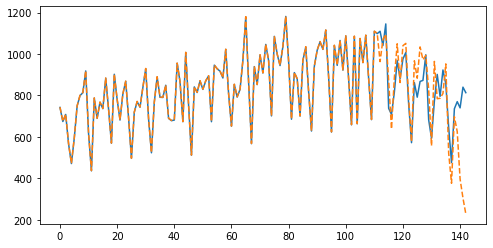

In [28]:
fig, ax = plt.subplots(figsize=(8, 4))
#accident_series[time_period].plot(ax=ax, marker=".")
#y_preds.plot(ax=ax, grid=True, legend=False)
plt.plot(X_array*1441, linestyle="solid")
plt.plot(ts["accident_num"]["2021-08-11":"2021-12"].tolist(), linestyle="dashed")
plt.show()

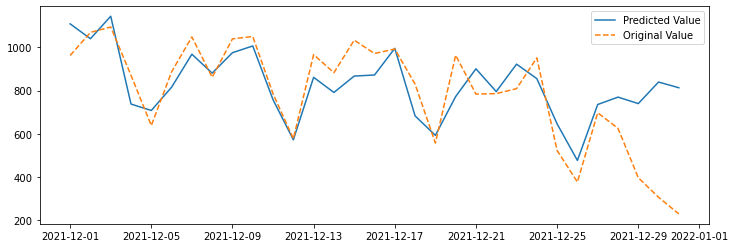

MAE: 122.19255365575513
MAPE: 26.174390801608276
RMSE: 180.80366866705683


In [29]:
fig, ax = plt.subplots(figsize=(12, 4))
#accident_series[time_period].plot(ax=ax, marker=".")
#y_preds.plot(ax=ax, grid=True, legend=False)
plt.plot(xaxis, X_array[len(X_array)-31:len(X_array)]*1441, linestyle="solid", label='Predicted Value')
plt.plot(xaxis, ts["accident_num"]["2021-12":].tolist(), linestyle="dashed", label='Original Value')
plt.legend()
plt.show()

mae = np.abs(ts["accident_num"]["2021-12":].tolist() - X_array[len(X_array)-31:len(X_array)]*1441).mean()
mape = 100*np.abs(((X_array[len(X_array)-31:len(X_array)]*1441 - ts["accident_num"]["2021-12":].tolist())/ts["accident_num"]["2021-12":].tolist())).mean()
rmse = ((X_array[len(X_array)-31:len(X_array)]*1441 - ts["accident_num"]["2021-12":].tolist())**2).mean()**0.5

print("MAE: "+str(mae))
print("MAPE: "+str(mape))
print("RMSE: "+str(rmse))